In [46]:
#For this demonstration I use a flat object and measure the variance of the depth estimation

In [47]:
import sys
sys.path.append('/usr/local/lib')

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.colors as mcol
import matplotlib.cm as cm
import math
import time
import pandas as pd
import json
import pyrealsense2 as rs
import cv2
from scipy import stats
from itertools import cycle
cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [49]:
# Enabling Advanced Mode

DS5_product_ids = ["0AD1", "0AD2", "0AD3", "0AD4", "0AD5", "0AF6", "0AFE", "0AFF", "0B00", "0B01", "0B03", "0B07"]

def find_device_that_supports_advanced_mode() :
    ctx = rs.context()
    ds5_dev = rs.device()
    devices = ctx.query_devices();
    for dev in devices:
        if dev.supports(rs.camera_info.product_id) and str(dev.get_info(rs.camera_info.product_id)) in DS5_product_ids:
            if dev.supports(rs.camera_info.name):
                print("Found device that supports advanced mode:", dev.get_info(rs.camera_info.name))
            return dev
    raise Exception("No device that supports advanced mode was found")

try:
    dev = find_device_that_supports_advanced_mode()
    advnc_mode = rs.rs400_advanced_mode(dev)
    print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    # Loop until we successfully enable advanced mode
    while not advnc_mode.is_enabled():
        print("Trying to enable advanced mode...")
        advnc_mode.toggle_advanced_mode(True)
        # At this point the device will disconnect and re-connect.
        print("Sleeping for 5 seconds...")
        time.sleep(5)
        # The 'dev' object will become invalid and we need to initialize it again
        dev = find_device_that_supports_advanced_mode()
        advnc_mode = rs.rs400_advanced_mode(dev)
        print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    
except Exception as e:
    print(e)
pass

Found device that supports advanced mode: Intel RealSense D415
Advanced mode is enabled


In [50]:
# Loading presaved parameters 
# If I have another set of parameters I'd like to use already in the json format, I can skip the previous three blocks of code
#called d415_default.json on my laptop 
#called d415paramset_1.json on my desktop
#win's is called canonical-params.json
with open("d415paramset_1.json") as json_data: #Json file to be loaded #notice How I am NOT using D415_params.json that I just created
    starting_params = json.load(json_data)
    starting_params=str(starting_params).replace("'", '\"') #IF YOU DON't DO THIS IT WILL NOT WORK with the librealsense sdk
    print(starting_params)

{"param-disableraucolor": "0", "param-disablesadcolor": "0", "param-disablesadnormalize": "0", "param-disablesloleftcolor": "0", "param-disableslorightcolor": "0", "param-lambdaad": "800", "param-lambdacensus": "26", "param-leftrightthreshold": "24", "param-maxscorethreshb": "2047", "param-medianthreshold": "500", "param-minscorethresha": "1", "param-neighborthresh": "7", "param-robbinsmonrodecrement": "10", "param-robbinsmonroincrement": "10", "param-secondpeakdelta": "325", "param-texturecountthresh": "0", "param-texturedifferencethresh": "0", "param-raumine": "1", "param-rauminn": "1", "param-rauminnssum": "3", "param-raumins": "1", "param-rauminw": "1", "param-rauminwesum": "3", "param-regionshrinku": "3", "param-regionshrinkv": "1", "param-regioncolorthresholdr": "0.05", "param-regioncolorthresholdg": "0.05", "param-regioncolorthresholdb": "0.05", "param-rsmdiffthreshold": "4", "param-rsmrauslodiffthreshold": "1", "param-rsmremovethreshold": "0.375", "param-usersm": "1", "param-sc

In [51]:
#Here I am getting the current values of all of the camera controls
current_ae_control=advnc_mode.get_ae_control()
current_census=advnc_mode.get_census()
current_color_control=advnc_mode.get_color_control()
current_color_correction=advnc_mode.get_color_correction()
current_depth_control=advnc_mode.get_depth_control()
current_depth_table=advnc_mode.get_depth_table()
current_hdad=advnc_mode.get_hdad()
current_rau_support_vector_control=advnc_mode.get_rau_support_vector_control()
current_rau_thresholds_control=advnc_mode.get_rau_thresholds_control()
current_rsm=advnc_mode.get_rsm()
current_slo_color_thresholds_control=advnc_mode.get_slo_color_thresholds_control()
current_slo_penalty_control=advnc_mode.get_slo_penalty_control()

In [52]:
#Here are some important parameters values

#Decent Defaults
paramvector=[400,9,9,0,0,0,0,0,.461914,.540039,.540039,.208008,-.332031,-.212891,-.212891,.68457,.930664,-.553711,-.553711,.458984,500,7,325,2,10,1,2047,0,0,65536,0,1000,0,0,0,800,26,1,1,3,1,1,3,0,0,51,51,51,4,63,0,1,72,72,72,60,105,70]
#Min Values
minparams=[400,1,1,0,0,0,0,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,800,26,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1]
#Max Values
maxparams=[400,9,9,1,1,1,1,1,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,1023,1023,1023,2047,255,1023,4095,1023,4095,65536,65536,10000,1,512,0,800,26,7,3,7,3,7,15,4,4,1022,1022,1022,7.96875,168,1,3.96875,1022,1022,1022,511,511,511]

In [53]:
#Recording Loop Initializations 

#camera specications
frame_width=640
frame_height=480
fps=90

#optimization specifications
number_of_frames_to_record=1000
background_length=500
background_chunk=int(number_of_frames_to_record/2) #I want to use 500 frames for recording the background

#open a file for apending binary data
file = open('pythondepthdata.bin', 'a+b')

# Configure depth stream
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, frame_width, frame_height, rs.format.z16, fps)
#config.enable_stream(rs.stream.color, frame_width, frame_height, rs.format.bgr8, fps)
advnc_mode.load_json(starting_params) #this is where I start with the Defualt Json

# Start streaming
cfg = pipeline.start(config)
dev = cfg.get_device()
depth_sensor = dev.first_depth_sensor()

In [54]:
start_of_loop=time.time()
saveddepthparams=[]
organizeddepthparams=[]
saveddepthparams.append(advnc_mode.get_depth_control())
organizeddepthparams.append(paramvector[20:29])
objectparamindex=0 #used to index the background parameters used in saveddepthparams list
tick=0; #keeping track of the number of loops the experiment has gone through 

#Main Recording Loop 

with open('pythondepthdata.bin','ab') as binarydata: #While the file called "pythonedpthdata.bin" is open for appending binary, 
    try:
        while tick<number_of_frames_to_record: 
            
            # Wait for a coherent pair of frames: depth and color
            frames=pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
        
            #First I want to record just the background
            #This is also where I prompt the user to insert a calibration object
            if tick==background_chunk:
                object_id=input("Background Recorded, Insert calibration object and enter data followed by the name of the object (format: YYMMDD_object)  ")
                            
            
            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            #color_image = np.asanyarray(color_frame.get_data())
            depth_image.tofile(binarydata) #save data as binarydata (specified by the with open as line)
            
                
            tick=tick+1 

    finally:

        # Stop streaming
        pipeline.stop()
        end_of_loop=time.time() #end timer
        print("Time Elapsed = ", end_of_loop - start_of_loop)
        #serialized_string = advnc_mode.serialize_json() #getting the current parameters as a serialized string
        #as_json_object = json.loads(serialized_string) #loading the json object from the serialized string
        #json_used_in_experiment = str(as_json_object).replace("'", '\"') #converting object into string that can be printed
        #print("Final Parameters = ", json_used_in_experiment)

Background Recorded, Insert calibration object and enter data followed by the name of the object (format: YYMMDD_object)  k
Time Elapsed =  17.81683325767517


In [55]:
#This is where I load the raw data and convert it into a numpy array
rawframes = np.fromfile('pythondepthdata.bin', dtype=np.uint16) #A highly efficient way of reading binary data with a known data-type, as well as parsing simply formatted text files. Data written using the tofile method can be read using this function.
frames = rawframes.reshape(-1, frame_height, frame_width) #.reshape simply restructures data into dimensions of your choosing. -1 means find the number of segments that structures the data into the dimnesions shown afterwards
del rawframes

In [56]:
number_of_frames,video_height,video_width=frames.shape[0],frames.shape[1],frames.shape[2];
#set number of frames equal to the first element in reshaped.shape
#set video height to the second element in reshaped.shape
#set video width to the third element in reshaped.shape
print('The shape of the video is {0} by {1} and it has {2} frames'.format(video_height,video_width,number_of_frames))
#note that the nubmers below are one greater than the actual indices that exist
#there is no reshaped[number_of_frames,height,width], the last frame is reshaped[number_of_frames-1,height-1,width-1]

The shape of the video is 480 by 640 and it has 1000 frames


In [57]:
#Testing Analysis For Every Parameter Set

mean_results=[]
median_results=[]
variance_results=[]


picked_frame= int(background_chunk+(background_chunk/2))
frame_of_interest=frames[picked_frame]
#know your background 
background_low_bounds=int(((picked_frame-(picked_frame%background_length))-background_chunk))
background_high_bounds=int(((picked_frame-(picked_frame%background_length))-background_chunk)+(background_length-1))
backgroundmean=np.median(frames[background_low_bounds:background_high_bounds], axis=0) #probably safer to do median since the noise is known to mean gaussian
backgroundvariance=np.var(frames[background_low_bounds:background_high_bounds], axis=0)

#if the difference between the background and the frame is greater than expected, it's probably our object! 
#note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian
backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (10*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE
#we expect positive values for high differences. make them stay by multiplying by 1
backgroundmultiplier[backgroundmultiplier>0]=1
#we expect negative values or no change for small differences. probably just noise, get rid of them by multiplying by 0
backgroundmultiplier[backgroundmultiplier<=0]=0
#apply our expectations to the matrix

frame_of_interest_backgroundsubtracted=np.multiply(np.subtract(frame_of_interest,backgroundmean),-1) #subtract the background mean and then multiply result by negative 1 since the camera counts distance away 
frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,backgroundmultiplier) #pixels that arent significantly different are considered background 
frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted<0]=0 #everything less than 0 IS zero
#frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,1) #go from mm to something else by mlitplying by something other than 1
frame_of_interest_backgroundsubtracted=np.rint(frame_of_interest_backgroundsubtracted) #makes everything an integer

#basic stats
object_median=np.median(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>0])
object_mean=np.mean(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
object_variance=np.var(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
#objectsigma=np.sqrt(objectvariance)
    
mean_results.append(object_mean)
median_results.append(object_median)
variance_results.append(object_variance)

#Plotting background-subtracted image
#fig=plt.figure(figsize=(10,10))
#plt.imshow(frame_of_interest_backgroundsubtracted)
#plt.clim(object_median-100,object_median+100)
#fig.savefig(object_id + '_%d.png'%i)

#same image with jet color bar
fig2=plt.figure(figsize=(8,8))
plt.colorbar(plt.imshow(frame_of_interest_backgroundsubtracted,cmap='jet'))
plt.clim(0,object_median+100) #starting at 0 instead of -100
#fig2.savefig(object_id + '_jet_%d.png'%i)

#show the stats
print('mean is %f' %object_mean)
print('median is %f' %object_median)
print('variance is %f' %object_variance)
    
#plt.close(fig)
plt.close(fig2)
    


mean is 107.270398
median is 54.000000
variance is 30406.200485


107.27039836
54.0
30406.2004853


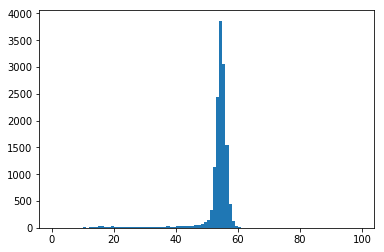

minusDecrement: 10, deepSeaMedianThreshold: 500, scoreThreshA: 1, scoreThreshB: 2047, textureDifferenceThreshold: 0, textureCountThreshold: 0, deepSeaSecondPeakThreshold: 325, deepSeaNeighborThreshold: 7, lrAgreeThreshold: 24


In [58]:
#plot histogram of the pixels with least variance
minvarindex=variance_results.index(min(variance_results)) #index of min variance image

picked_frame=int(((background_length*minvarindex)+background_chunk+(background_length/2))) #Picked frames greater than the background chunk should show image of object,every 100 frames use different parameters
frame_of_interest=frames[picked_frame]
#know your background 
background_low_bounds=int(((picked_frame-(picked_frame%background_length))-background_chunk))
background_high_bounds=int(((picked_frame-(picked_frame%background_length))-background_chunk)+(background_length-1))
backgroundmean=np.median(frames[background_low_bounds:background_high_bounds], axis=0) #probably safer to do median since the noise is known to mean gaussian
backgroundvariance=np.var(frames[background_low_bounds:background_high_bounds], axis=0)

#if the difference between the background and the frame is greater than expected, it's probably our object! 
#note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian
backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (10*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE
#we expect positive values for high differences. make them stay by multiplying by 1
backgroundmultiplier[backgroundmultiplier>0]=1
#we expect negative values or no change for small differences. probably just noise, get rid of them by multiplying by 0
backgroundmultiplier[backgroundmultiplier<=0]=0
#apply our expectations to the matrix

frame_of_interest_backgroundsubtracted=np.multiply(np.subtract(frame_of_interest,backgroundmean),-1) #subtract the background mean and then multiply result by negative 1 since the camera counts distance away 
frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,backgroundmultiplier) #pixels that arent significantly different are considered background 
frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted<0]=0 #everything less than 0 IS zero
#frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,1) #go from mm to something else by mlitplying by something other than 1
frame_of_interest_backgroundsubtracted=np.rint(frame_of_interest_backgroundsubtracted) #makes everything an integer

#basic stats
object_median=np.median(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>0])
object_mean=np.mean(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
object_variance=np.var(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
print(object_mean)
print(object_median)
print(object_variance)
plt.hist(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0],bins=range(1,100))
plt.show()
print(saveddepthparams[int((background_low_bounds/background_length))]) #print the depth parameters that led to this histogram

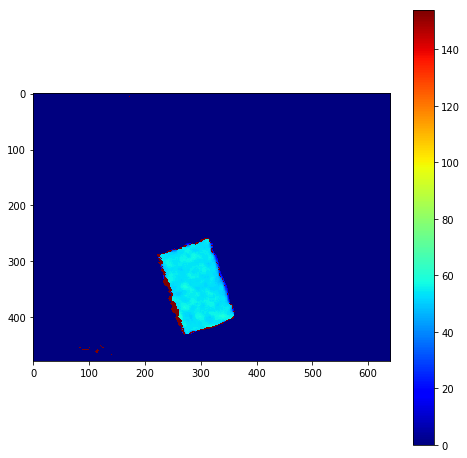

In [59]:
plt.figure(figsize=(8,8))
plt.colorbar(plt.imshow(frame_of_interest_backgroundsubtracted,cmap='jet'))
plt.clim(0,object_median+100) #starting at 0 instead of -100

In [60]:
!rm pythondepthdata.bin